# Decision Tree Classification PostClass

## Decision Tree Theory
- Dataya sorular sorarak classification ve regression yapan bir modeldir.
- Non-parametric bir modeldir bu yüzden outlier'lardan etkilenmez.
- Multi-collinearity'den etkilenmez.
- Tıbbi tanılarda, metin sınıflandırmada ve kredi risk analizinde kullanılır.
- Overfitting'e açık bir algoritmaya sahiptir.
- Sub-decision ve leaf'lerde saflığı sağlayacak şekilde bölünmeye karar verir.
- Bölünmeye hangi feature'dan başlayacağımıza karar verirken Gini index ve Information Gain hesaplarız.
- Gini index heterojenliği minimize edecekşekilde çalışır.
- Gini index'in minimum, information Gain'in maximum olmasını istiyoruz.
- Information gain, entropi üzerinden hesaplanır. Entropi azaldıkça information gain artar.
- Olasılık 0.5 iken entropi maximum olur.

### Hyper Parameters:
1. **criterion :** Default değeri "gini" dir. Modelin hangi yöntemle bölünmeye başlayacağını belirler.
2. **max-depth :** Default değeri "None" dır. Karar ağacı ne kadar dallanacak onu belirlemek için kullanılır. Model acil müdahale gerktiğinde score'ları düzeltmek için ilk düzenleme bu parametre üzerinden yapılır. Tree-based modellerde en önemli parametre budur.
3. **splitter :** Default değeri "best" dir. Best olması durumunda en uygun feature hangisi ise bölünmeye ondan başlar. Diğer bir seçenek de "random" seçmektir.
4. **max-features :** Default değeri "None" dır. Kaç feature üzerinden bölünme yapılacağını belirlemekte kullanılır.
5. **min-samples-split :** Default değeri 2'dir.
6. **min-samples-leaf :** Default değeri 1'dir.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.rcParams["figure.figsize"] = (10, 6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [47]:
df = pd.read_csv("penguins_size.csv")
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


## Exploratory Data Analysis and Visualization

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [49]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [50]:
df.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [51]:
10 / 344
# Datamızın sadece % 2.9 u null değer. Tamamını düşmek bize bir kayıp sağlamaz diyebiliriz.

0.029069767441860465

In [52]:
df.dropna(inplace=True)

In [53]:
df["sex"].unique()
# Burada cinsiyet sütununda "." değeri var. Bunu drop edecez.

array(['MALE', 'FEMALE', '.'], dtype=object)

In [54]:
df[df["sex"] == "."]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


In [55]:
df.drop(index=336, inplace=True)

In [56]:
df2 = df.copy()
# Daha sonra lazım olabileceği için dataframe'in bir kopyasını alıyoruz.

## Visualization

In [57]:
df["species"].value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

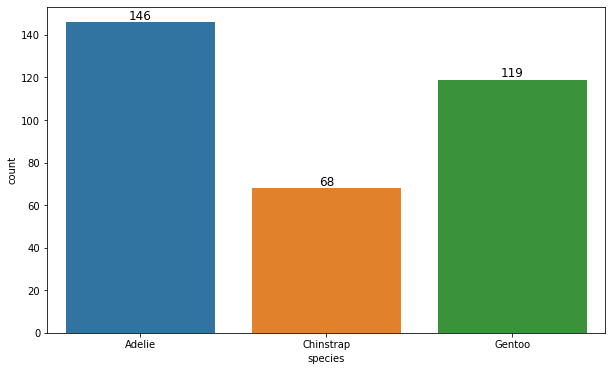

In [58]:
ax = sns.countplot(x = "species", data=df)

for i in ax.containers:
    ax.bar_label(i, size=12)

# Burada target feature'umuzda türler arasında balance durumu yok gözüküyor. 
# Ancak imbalance durum var diyebilmek için skore'larımıza bakarak yorum yapmalıyız.

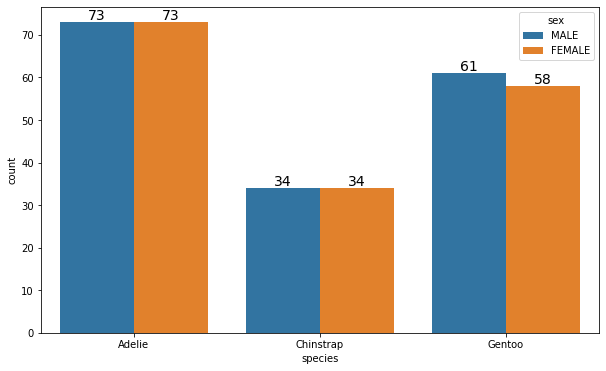

In [59]:
ax = sns.countplot(x="species", hue="sex", data=df)

for i in ax.containers:
    ax.bar_label(i, size=14)
    
# Burada türler içinde cinsiyetlerin eşit dağılım gösterdiğini görüyoruz.

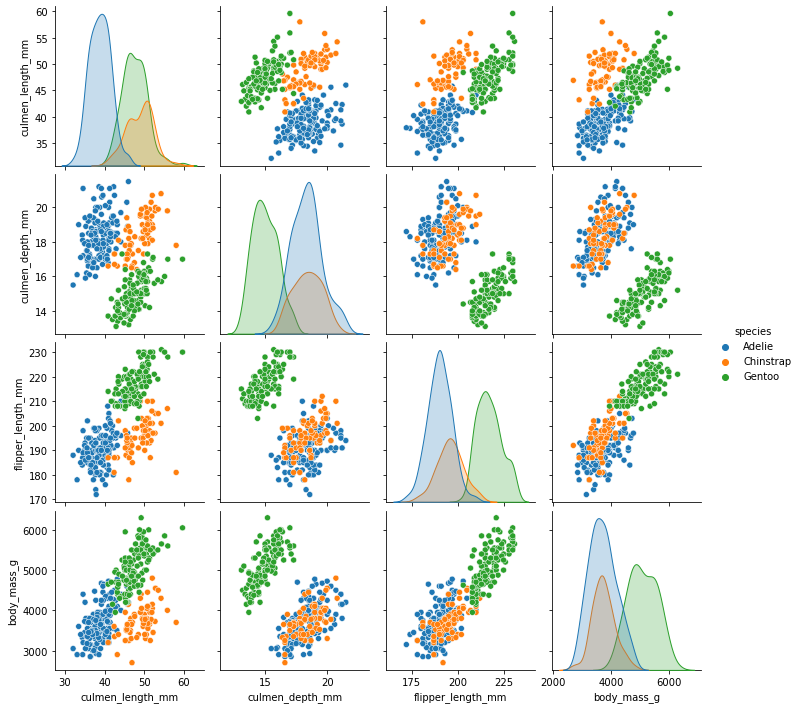

In [60]:
sns.pairplot(df, hue="species");
# Burada iki boyutlu grafiğe bakınca "Adelie" türü ile "Chinstrap" türünün üst üste bindiğini ayrılamayacağını görüyoruz.
# Ancak 3 boyutlu grafiğe bakmadan birşey söylemek doğru olmaz.

In [61]:
df["species"].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [62]:
fig = px.scatter_3d(data_frame=df, 
                    x = "culmen_length_mm",
                    y = "flipper_length_mm",
                    z = "culmen_depth_mm",
                    color = "species")
fig.show()

# Burada 3 boyutlu grafiğe bakınca 3 türün de birbirinden ayrılabileceğini ve modelimin iyi bir skor alacaığını görüyorum.

## Correlation Between Numeric Features

In [63]:
df.select_dtypes("number")

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
338,47.2,13.7,214.0,4925.0
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


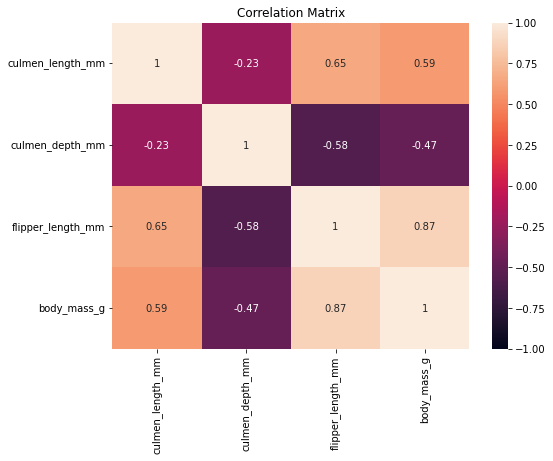

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes("number").corr(), annot=True, vmin=-1)
plt.title("Correlation Matrix");

# Burada "flipper_length" ile "body_mass" arasında yüksek korelasyon görüyoruz. Collinearity var diyebiliriz.
# Ancak modelimiz non-parametric olduğu için bu durum bize sorun teşkil etmiyor.

## Train-Test Split

In [65]:
X = df2.drop(columns="species")
y = df2["species"]

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## OrdinalEncoder and Categoric Variable 

In [68]:
# Daha önce kategorik feature'lar için OneHotEncoder kullanacağımızı söylemiştik.
# Ancak Tree-based modellerde OrdinalEncoder yapacağız ve bunun sebepleri var:
    # Feature sayısını artırmadan nominal şekilde sıralama yaptığı için daha HIZLI.
    # Score'larda % 1-2 arası İYİLEŞME.
    # FEATURE IMPORTANCE için OrdinalEncoder kullanılması gerekiyor.

In [69]:
cat = X_train.select_dtypes("object").columns
cat

Index(['island', 'sex'], dtype='object')

In [70]:
X_train[cat]

,island,sex
314,Biscoe,FEMALE
248,Biscoe,FEMALE
199,Dream,MALE
182,Dream,FEMALE
238,Biscoe,FEMALE
...,...,...
81,Torgersen,MALE
93,Dream,MALE
69,Torgersen,MALE
335,Biscoe,MALE


In [71]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
enc.fit_transform(X_train[cat])

array([[0., 0.],
       [0., 0.],
       [1., 1.],
       [1., 0.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [2., 1.],
       [1., 0.],
       [1., 1.],
       [2., 0.],
       [1., 0.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [2., 1.],
       [0., 1.],
       [1., 1.],
       [1., 1.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [1., 1.],
       [2., 1.],
       [0., 1.],
       [0., 1.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [0., 1.],
       [1., 1.],
       [0., 0.],
       [0., 1.],
       [1., 1.],
       [2., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.

In [72]:
X_train[cat] = enc.fit_transform(X_train[cat])
X_train[cat]

# Burada Ordinal encoder'ın island ve sex'te bulunan kategorilere göre 0'dan başlayarak sayı verdiğini görüyoruz.

,island,sex
314,0.0,0.0
248,0.0,0.0
199,1.0,1.0
182,1.0,0.0
238,0.0,0.0
...,...,...
81,2.0,1.0
93,1.0,1.0
69,2.0,1.0
335,0.0,1.0


In [73]:
X_train.head()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
314,0.0,44.5,14.7,214.0,4850.0,0.0
248,0.0,48.2,14.3,210.0,4600.0,0.0
199,1.0,49.0,19.6,212.0,4300.0,1.0
182,1.0,40.9,16.6,187.0,3200.0,0.0
238,0.0,46.2,14.5,209.0,4800.0,0.0


In [74]:
X_test[cat] = enc.transform(X_test[cat])
X_test[cat]

,island,sex
171,1.0,1.0
250,0.0,1.0
140,1.0,0.0
130,2.0,0.0
214,1.0,0.0
...,...,...
156,1.0,1.0
70,2.0,0.0
78,2.0,0.0
287,0.0,1.0


In [75]:
X_test.head()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
171,1.0,49.2,18.2,195.0,4400.0,1.0
250,0.0,47.3,15.3,222.0,5250.0,1.0
140,1.0,40.2,17.1,193.0,3400.0,0.0
130,2.0,38.5,17.9,190.0,3325.0,0.0
214,1.0,45.7,17.0,195.0,3650.0,0.0


In [ ]:
# Buraya kadar olan kısımda OrdinalEncoder'ın tanıtımı amaçlı kodlama yaptık.
# Şimdi pipeline ile uygulamasını göreceğiz.

## Modeling with Pipeline

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [78]:
cat

Index(['island', 'sex'], dtype='object')

In [81]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
column_trans = make_column_transformer((ord_enc, cat), remainder="passthrough")

# handle_unknown = "use_encoded_value", unknown_value = -1 yazdık. Bunun anlamı şu:
# Eğer ilk defa gördüğü bir değer ile karşılaşırsa encoded value'yu kullanmasını istiyoruz.
# encoded_value' yu da unkwnon_value içinde belirtiyoruz. Yani ilk defa karşılaştığı değere -1 atayacak.
#-1 seçtşk çünkü ordinalEncoder 0'dan başlayarak değer ataması yapıyor...

# Burada bir de make_column_transformer kullandık. Sütunlar üzerinde işlem yapmak için bu fonksiyonu kullanıyoruz.
# Burada remainde = "passthrough" diye belirttik.
# Burada fonksiyon önce cat değişkeni içindeki categorilere ord_enc uygulayacak sonra geri kalan featureları pas geçecek...

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

operations = [("OrdinalEncoder", column_trans), ("DT_model", DecisionTreeClassifier(random_state=101))]

pipe_model = Pipeline(steps = operations)

pipe_model.fit(X_train, y_train)

# Burada pipeline, önce categoric sütunları dönüştürdü sonra da modelimizi uyguladı.

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('DT_model', DecisionTreeClassifier(random_state=101))])

## Model Performance on Classification Tasks

In [83]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

In [89]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

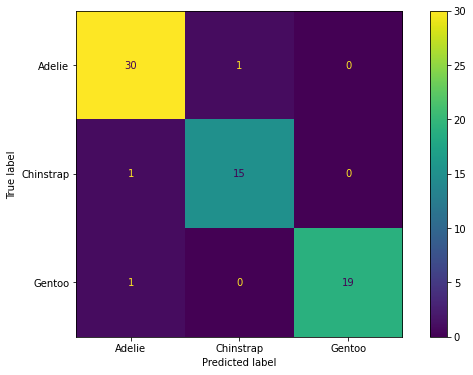

In [86]:
plot_confusion_matrix(pipe_model, X_test, y_test);

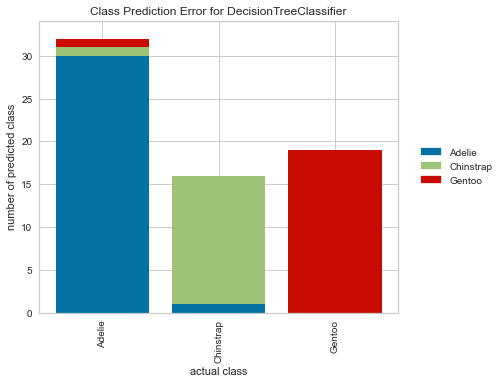

In [87]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(pipe_model)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.poof();

In [90]:
eval_metric(pipe_model, X_train, y_train, X_test, y_test);

Test_Set
[[30  1  0]
 [ 1 15  0]
 [ 1  0 19]]
              precision    recall  f1-score   support

      Adelie       0.94      0.97      0.95        31
   Chinstrap       0.94      0.94      0.94        16
      Gentoo       1.00      0.95      0.97        20

    accuracy                           0.96        67
   macro avg       0.96      0.95      0.95        67
weighted avg       0.96      0.96      0.96        67


Train_Set
[[115   0   0]
 [  0  52   0]
 [  0   0  99]]
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       115
   Chinstrap       1.00      1.00      1.00        52
      Gentoo       1.00      1.00      1.00        99

    accuracy                           1.00       266
   macro avg       1.00      1.00      1.00       266
weighted avg       1.00      1.00      1.00       266



In [92]:
# Eval-metric sonrası skor'larımız iyi çıktı. 
# Test ve Train skore'ları birbirine yakın olduğu için datamızı balance olarak değerlendirebiliriz.
# Datamızı balance olarak değerlendirdiğimiz için Accuracy score üzerinden değerlendirme yapacağız.
# Data dengeli olduğunda micro score'lar accuracy ile aynı olur.

# Burada train score'larının tamamı 1 olması şüphe uyandırabilir. 
# İki yaklaşım var birincisi train datasında da bir miktar hata olmalı, ikincisi ise model tam anlamıyla öğrenmiş diyebiliriz.
# Yaklaşımınıza göre model'e hata ekleyip eklememeye karar verirsiniz.

# Ama burada overfitting yok gözüküyor.
# Yine de cross validation yapmadan kesin bir kanıya varmak doğru olmayabilir.

## Cross Validate

In [93]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer

In [95]:
operations = [("OrdinalEncoder", column_trans), ("DT_model", DecisionTreeClassifier(random_state=101))]
model = Pipeline(steps=operations)

scores = cross_validate(model, X_train, y_train, scoring=["accuracy", "precision_micro", "recall_micro", "f1_micro"], cv=10)

df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores

,fit_time,score_time,test_accuracy,test_precision_micro,test_recall_micro,test_f1_micro
1,0.002989,0.003994,0.925926,0.925926,0.925926,0.925926
2,0.004021,0.003033,1.000000,1.000000,1.000000,1.000000
3,0.003148,0.001998,0.888889,0.888889,0.888889,0.888889
4,0.002066,0.002996,1.000000,1.000000,1.000000,1.000000
5,0.001992,0.001995,1.000000,1.000000,1.000000,1.000000
6,0.003004,0.001978,1.000000,1.000000,1.000000,1.000000
7,0.002008,0.002980,1.000000,1.000000,1.000000,1.000000
8,0.001997,0.001984,1.000000,1.000000,1.000000,1.000000
9,0.001996,0.002919,0.961538,0.961538,0.961538,0.961538
10,0.003062,0.001992,0.961538,0.961538,0.961538,0.961538


In [97]:
df_scores.mean()[2:]
# Burada test score'um validation öncesine göre 1 puan daha fazla çıktı.

test_accuracy           0.973789
test_precision_micro    0.973789
test_recall_micro       0.973789
test_f1_micro           0.973789
dtype: float64

## Evaluating ROC Curve and AUC

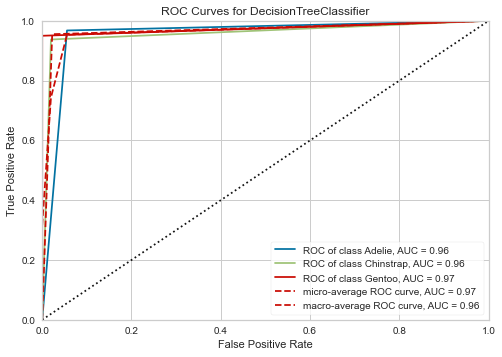

In [99]:
from yellowbrick.classifier import ROCAUC

model = pipe_model

visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train) # Fit the training data to the visualizer.
visualizer.score(X_test, y_test) # Evaluate the model on the test data.
visualizer.show();               # Finalize and render the figure.

## Feature Importance with Pipeline

In [101]:
pipe_model["DT_model"].feature_importances_

# Burada feature'ların importance'larının sayısal değerlerini görüyoruz.
# Toplamı 1'e eşit.

# Buradaki sıralama bizim df sıralamamız ile uyuşmuyor çünkü OrdinalEncoder sonrası categoric sütunlar en başa geliyor.
# Bu sıralamaya dikkat etmek ve kontrol etmek ÖNEMLİ.


array([0.03327601, 0.02363079, 0.35128085, 0.04724943, 0.54456291,
       0.        ])

In [103]:
X_train.head(1)
# Normalde dataframe'deki feature sıralaması buradaki gibi.

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
314,Biscoe,44.5,14.7,214.0,4850.0,FEMALE


In [105]:
pd.DataFrame(pipe_model["OrdinalEncoder"].fit_transform(X_train))
# Ama Ordinal encoder sonrası 0 ve 1 numaralı sütunu incelerseniz bu iki feature un categoricler olduğunu anlarsınız.
# Burada 0 = island ve 1 = sex feature'larıdır. island 0-3 aralığında ve sex 0-1 aralığında...

,0,1,2,3,4,5
0,0.0,0.0,44.5,14.7,214.0,4850.0
1,0.0,0.0,48.2,14.3,210.0,4600.0
2,1.0,1.0,49.0,19.6,212.0,4300.0
3,1.0,0.0,40.9,16.6,187.0,3200.0
4,0.0,0.0,46.2,14.5,209.0,4800.0
...,...,...,...,...,...,...
261,2.0,1.0,42.9,17.6,196.0,4700.0
262,1.0,1.0,39.6,18.1,186.0,4450.0
263,2.0,1.0,41.8,19.4,198.0,4450.0
264,0.0,1.0,55.1,16.0,230.0,5850.0


In [106]:
X_train.columns

Index(['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex'],
      dtype='object')

In [110]:
list(X_train.select_dtypes("object"))

['island', 'sex']

In [111]:
list(X_train.select_dtypes("number"))

['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

In [112]:
features = list(X_train.select_dtypes("object")) + list(X_train.select_dtypes("number"))
features

# Burada feature'ların sıralamasını düzelttik.
# Şimdi feature importance'lara bakabiliriz.

['island',
 'sex',
 'culmen_length_mm',
 'culmen_depth_mm',
 'flipper_length_mm',
 'body_mass_g']

In [115]:
df_f_i = pd.DataFrame(data = pipe_model["DT_model"].feature_importances_,
                      index = features,
                      columns = ["Feature Importance"]).sort_values(by = "Feature Importance", ascending=False)
df_f_i

# Buradan en önemli feature'umuzun flipper_length olduğunu anlıyoruz. Modelimiz karar ağacına bu feature ile başlayacak.

# Bazen feature importance'ı en yüksek olan feature eğer diğer featurelara baskın geliyorsa overfitting'e neden olabilir.
# Bizim data'mızda da flipper_length çok baskın gözüküyor.
# Genelde en önemli feature'u atıp bir de öyle score'lara bakmak lazım.
    # Eğer score'larda iyileşme varsa demek ki bu feature overfitting'e neden olmuş diyip bu feature'u atabiliriz.
    # Bu durumla her zaman olmasa da bazen karşılaşabilirsiniz. O yüzden bunu uygulamalısınız.

,Feature Importance
flipper_length_mm,0.544563
culmen_length_mm,0.351281
culmen_depth_mm,0.047249
island,0.033276
sex,0.023631
body_mass_g,0.000000


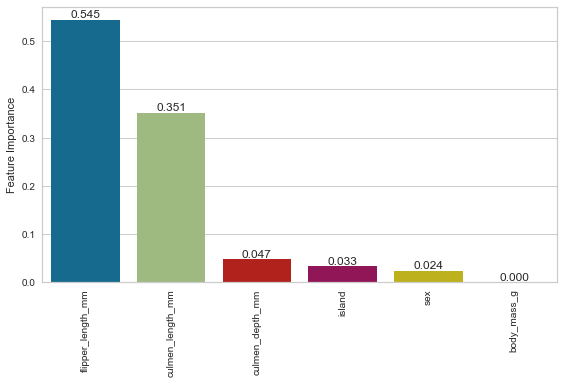

In [118]:
ax = sns.barplot(x = df_f_i.index, y = "Feature Importance", data = df_f_i)

for i in ax.containers:
    ax.bar_label(i, fmt = "%.3f")
    
plt.xticks(rotation = 90)
plt.tight_layout()

## Drop Most Important Feature 

In [120]:
X.head(1)

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,MALE


In [121]:
X2 = X.drop(columns="flipper_length_mm")

In [125]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=101)

In [126]:
operations = [("OrdinalEncoder", column_trans), ("DT_model", DecisionTreeClassifier(random_state=101))]

pipe_model2 = Pipeline(steps = operations)

pipe_model2.fit(X_train2, y_train2)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('DT_model', DecisionTreeClassifier(random_state=101))])

In [127]:
eval_metric(pipe_model2, X_train2, y_train2, X_test2, y_test2)

Test_Set
[[30  1  0]
 [ 0 16  0]
 [ 0  0 20]]
              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        31
   Chinstrap       0.94      1.00      0.97        16
      Gentoo       1.00      1.00      1.00        20

    accuracy                           0.99        67
   macro avg       0.98      0.99      0.98        67
weighted avg       0.99      0.99      0.99        67


Train_Set
[[115   0   0]
 [  0  52   0]
 [  0   0  99]]
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       115
   Chinstrap       1.00      1.00      1.00        52
      Gentoo       1.00      1.00      1.00        99

    accuracy                           1.00       266
   macro avg       1.00      1.00      1.00       266
weighted avg       1.00      1.00      1.00       266



In [128]:
# Burada most important feature'u attıktan sonra score'umuzda 2 puanlık bir iyileşme oldu.
# Ancak cross_validation yapmadan kesin birşey söylemek mümkün değil.

In [129]:
operations = [("OrdinalEncoder", column_trans), ("DT_model", DecisionTreeClassifier(random_state=101))]

model = Pipeline(steps=operations)

scores = cross_validate(model, X_train2, y_train2, scoring=["accuracy", "precision_micro", "recall_micro", "f1_micro"], cv=10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores

,fit_time,score_time,test_accuracy,test_precision_micro,test_recall_micro,test_f1_micro
1,0.003987,0.004081,0.962963,0.962963,0.962963,0.962963
2,0.002897,0.003001,1.000000,1.000000,1.000000,1.000000
3,0.002002,0.003051,0.925926,0.925926,0.925926,0.925926
4,0.002989,0.001994,1.000000,1.000000,1.000000,1.000000
5,0.002003,0.001986,1.000000,1.000000,1.000000,1.000000
6,0.001999,0.001987,0.962963,0.962963,0.962963,0.962963
7,0.000997,0.002993,1.000000,1.000000,1.000000,1.000000
8,0.000993,0.003028,1.000000,1.000000,1.000000,1.000000
9,0.001955,0.001991,1.000000,1.000000,1.000000,1.000000
10,0.002000,0.002991,1.000000,1.000000,1.000000,1.000000


In [130]:
df_scores.mean()[2:]

test_accuracy           0.985185
test_precision_micro    0.985185
test_recall_micro       0.985185
test_f1_micro           0.985185
dtype: float64

In [133]:
# Burada most important feature'u atmadan aldığımız cross_validaton scoreları ile sonrasını karşılaştırdık.
# En önemli feature'u atınca score'larımızda 1 puanlık bir iyileşme oldu.
# En önemli feature'u atmaya karar verdik.

## Adelie-Chinstrap Weighted Metric Scores

In [134]:
from sklearn.metrics import make_scorer

In [136]:
scoring = {
           "precision-Adelie-Chinstrap" : make_scorer(precision_score, average = "weighted", labels=["Adelie", "Chinstrap"]),
           "recall-Adelie-Chinstrap" : make_scorer(recall_score, average = "weighted", labels = ["Adelie", "Chinstrap"]),
           "f1-Adelie-Chinstrap" : make_scorer(f1_score, average="weighted", labels = ["Adelie", "Chinstrap"])
          }
# Burada birden fazla sınıfa ait score'a baktığımız için average = "weighted" yazdık.
# Eğer tek bir sınıfa ait score'a baksaydık average = "None" yazacakatık.

In [140]:
operations = [("OrdinalEncoder", column_trans), ("DT_model", DecisionTreeClassifier(random_state=101))]

model = Pipeline(steps = operations)

scores = cross_validate(model, X_train2, y_train2, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

test_precision-Adelie-Chinstrap    0.981303
test_recall-Adelie-Chinstrap       0.982353
test_f1-Adelie-Chinstrap           0.979985
dtype: float64

## Visualize the Tree

In [141]:
from sklearn.tree import plot_tree

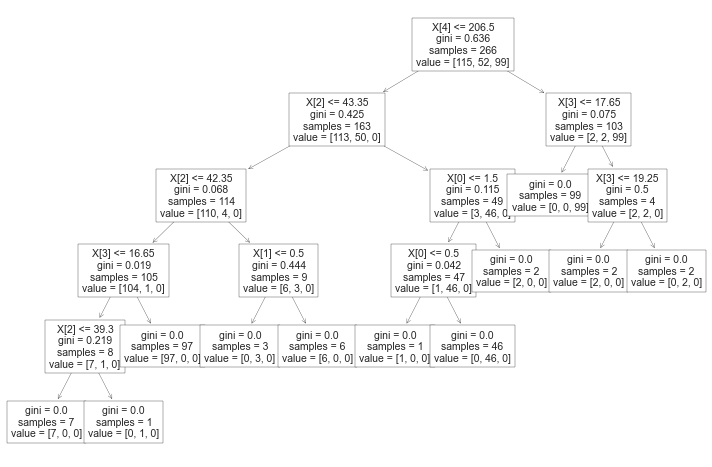

In [142]:
plt.figure(figsize=(12, 8), dpi=75)
plot_tree(pipe_model["DT_model"], fontsize=10);
# Bunu biraz daha göze hitap edecek şekilde  yapacağız.

In [143]:
features

['island',
 'sex',
 'culmen_length_mm',
 'culmen_depth_mm',
 'flipper_length_mm',
 'body_mass_g']

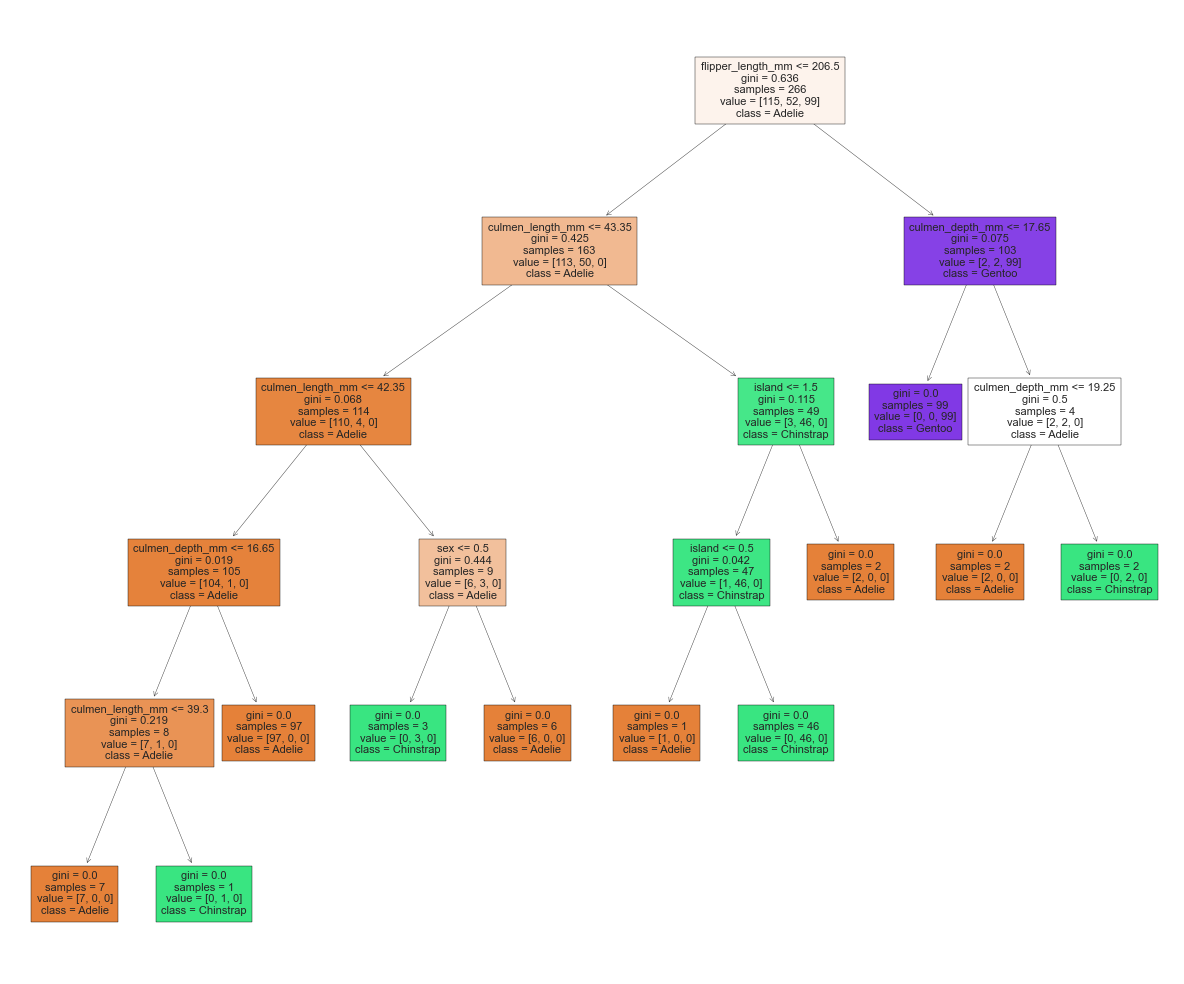

In [149]:
plt.figure(figsize=(12, 10), dpi=100)
plot_tree(pipe_model["DT_model"], filled=True, feature_names=features, class_names=y.unique(), fontsize=8)
plt.tight_layout()

## Understanding Hyperparameters
### criterion, max-depth, splitter, max-features, min-samples-split, min-samples-leaf

In [153]:
def report_model(model):
    model_pred = model.predict(X_test)
    model_train_pred = model.predict(X_train)
    print('\n')
    print("Test Set")
    print(confusion_matrix(y_test, model_pred))
    print('\n')
    print(classification_report(y_test,model_pred))
    print('\n')
    print("Train Set")
    print(confusion_matrix(y_train, model_train_pred))
    print('\n')
    print(classification_report(y_train,model_train_pred))
    
    plt.figure(figsize=(12,8),dpi=100)
    plot_tree(model["DT_model"], filled=True, feature_names=features, class_names = y.unique(), fontsize=10);

### max_depth

In [154]:
DT_model = DecisionTreeClassifier(max_depth=2, random_state=101)
operations = [("OrdinalEncoder", column_trans), ("DT_model", DT_model)]

pruned_tree = Pipeline(steps = operations)
pruned_tree.fit(X_train, y_train)

# Burada ilk müdehaleyi max_depth'i değiştirerek yaptık. Ancak ileride GridSearch ile optimum parametreleri bulacağız.

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('DT_model',
                 DecisionTreeClassifier(max_depth=2, random_state=101))])



Test Set
[[30  1  0]
 [ 4 12  0]
 [ 0  1 19]]


              precision    recall  f1-score   support

      Adelie       0.88      0.97      0.92        31
   Chinstrap       0.86      0.75      0.80        16
      Gentoo       1.00      0.95      0.97        20

    accuracy                           0.91        67
   macro avg       0.91      0.89      0.90        67
weighted avg       0.91      0.91      0.91        67



Train Set
[[112   3   0]
 [  6  46   0]
 [  0   0  99]]


              precision    recall  f1-score   support

      Adelie       0.95      0.97      0.96       115
   Chinstrap       0.94      0.88      0.91        52
      Gentoo       1.00      1.00      1.00        99

    accuracy                           0.97       266
   macro avg       0.96      0.95      0.96       266
weighted avg       0.97      0.97      0.97       266



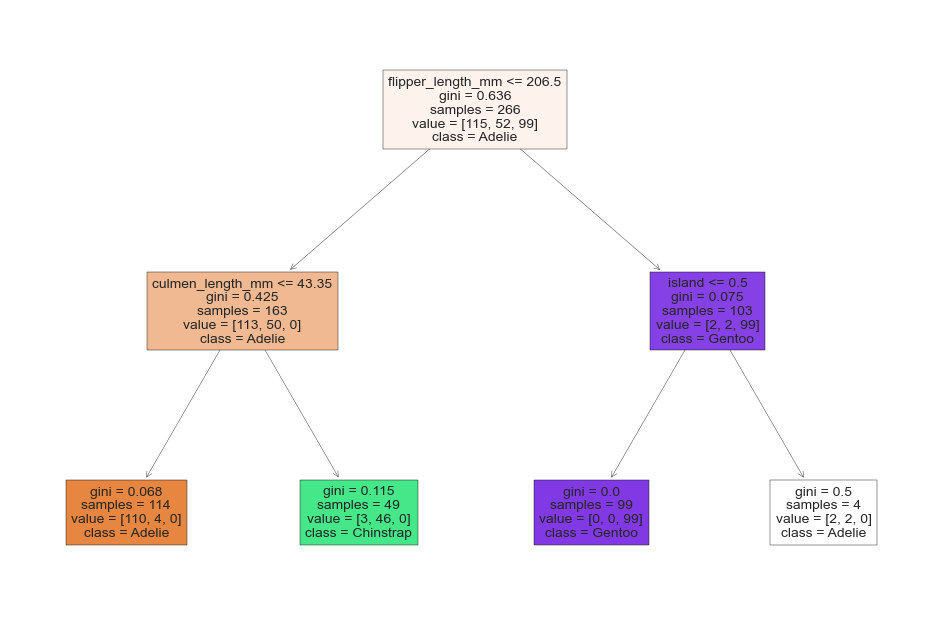

In [155]:
report_model(pruned_tree)

### max_leaf_nodes

In [157]:
DT_model = DecisionTreeClassifier(max_leaf_nodes=7, random_state=101)
operations = [("OrdinalEncoder", column_trans), ("DT_model", DT_model)]

pruned_tree_2 = Pipeline(steps = operations)
pruned_tree_2.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('DT_model',
                 DecisionTreeClassifier(max_leaf_nodes=7, random_state=101))])



Test Set
[[30  1  0]
 [ 2 14  0]
 [ 1  0 19]]


              precision    recall  f1-score   support

      Adelie       0.91      0.97      0.94        31
   Chinstrap       0.93      0.88      0.90        16
      Gentoo       1.00      0.95      0.97        20

    accuracy                           0.94        67
   macro avg       0.95      0.93      0.94        67
weighted avg       0.94      0.94      0.94        67



Train Set
[[115   0   0]
 [  4  48   0]
 [  0   0  99]]


              precision    recall  f1-score   support

      Adelie       0.97      1.00      0.98       115
   Chinstrap       1.00      0.92      0.96        52
      Gentoo       1.00      1.00      1.00        99

    accuracy                           0.98       266
   macro avg       0.99      0.97      0.98       266
weighted avg       0.99      0.98      0.98       266



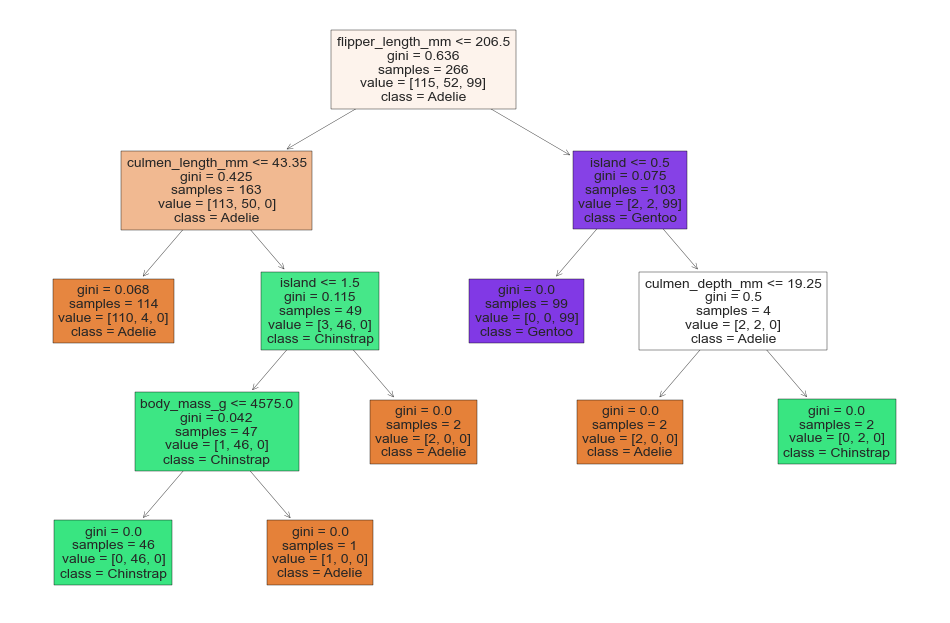

In [158]:
report_model(pruned_tree_2)

### criterion

In [159]:
DT_model = DecisionTreeClassifier(criterion="entropy", random_state=101)
operations = [("OrdinalEncoder", column_trans), ("DT_model", DT_model)]

entropy_tree = Pipeline(steps = operations)

entropy_tree.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('DT_model',
                 DecisionTreeClassifier(criterion='entropy',
                                        random_state=101))])



Test Set
[[30  1  0]
 [ 1 15  0]
 [ 1  0 19]]


              precision    recall  f1-score   support

      Adelie       0.94      0.97      0.95        31
   Chinstrap       0.94      0.94      0.94        16
      Gentoo       1.00      0.95      0.97        20

    accuracy                           0.96        67
   macro avg       0.96      0.95      0.95        67
weighted avg       0.96      0.96      0.96        67



Train Set
[[115   0   0]
 [  0  52   0]
 [  0   0  99]]


              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       115
   Chinstrap       1.00      1.00      1.00        52
      Gentoo       1.00      1.00      1.00        99

    accuracy                           1.00       266
   macro avg       1.00      1.00      1.00       266
weighted avg       1.00      1.00      1.00       266



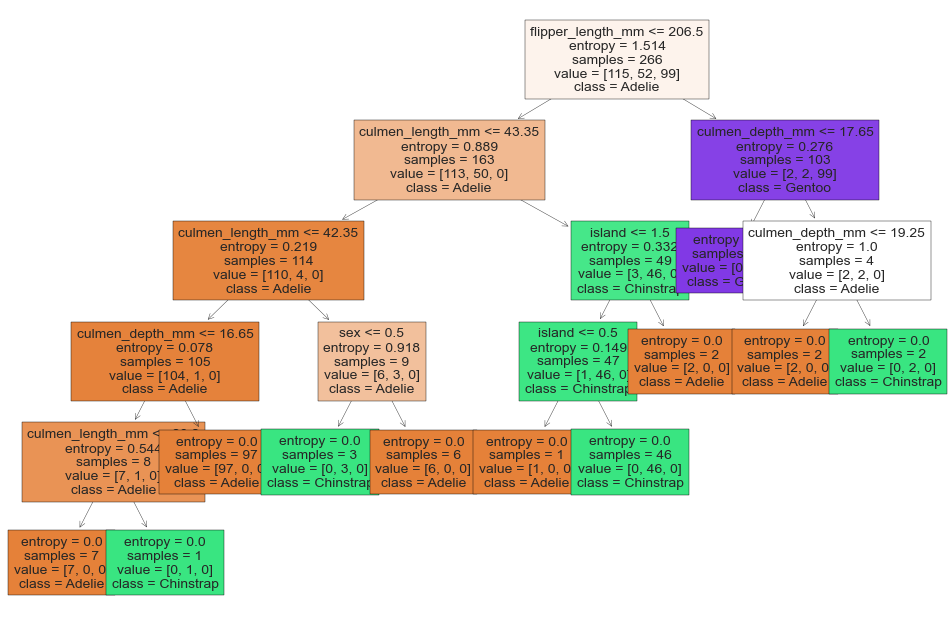

In [160]:
report_model(entropy_tree)

### max_features, splitter

In [161]:
DT_model = DecisionTreeClassifier(splitter="random", max_features=3)
operations = [("OrdinalEncoder", column_trans), ("DT_model", DT_model)]

tree = Pipeline(steps = operations)

tree.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('DT_model',
                 DecisionTreeClassifier(max_features=3, splitter='random'))])



Test Set
[[30  1  0]
 [ 0 16  0]
 [ 0  0 20]]


              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        31
   Chinstrap       0.94      1.00      0.97        16
      Gentoo       1.00      1.00      1.00        20

    accuracy                           0.99        67
   macro avg       0.98      0.99      0.98        67
weighted avg       0.99      0.99      0.99        67



Train Set
[[115   0   0]
 [  0  52   0]
 [  0   0  99]]


              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       115
   Chinstrap       1.00      1.00      1.00        52
      Gentoo       1.00      1.00      1.00        99

    accuracy                           1.00       266
   macro avg       1.00      1.00      1.00       266
weighted avg       1.00      1.00      1.00       266



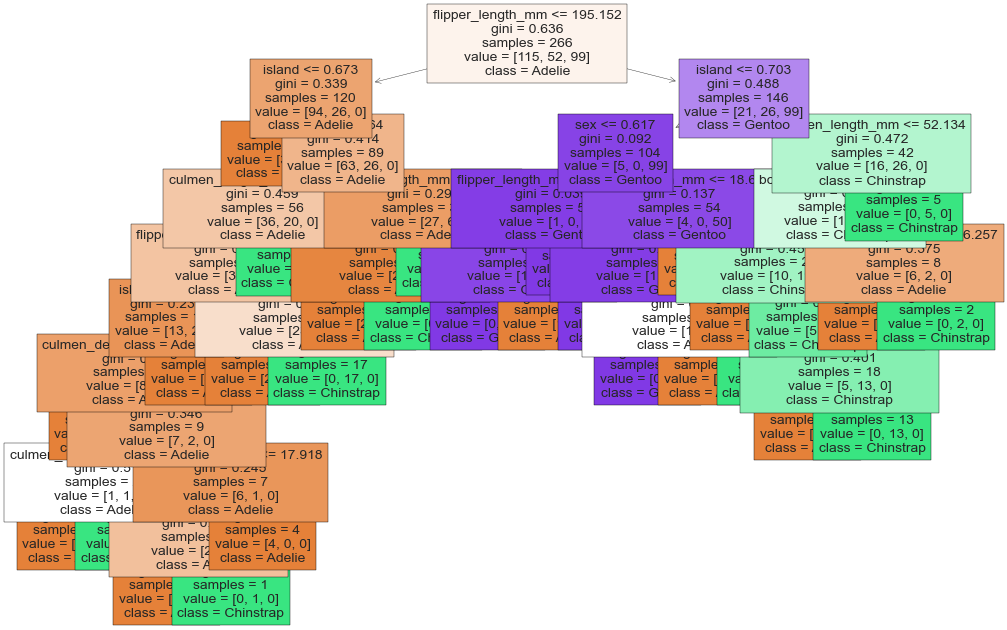

In [162]:
report_model(tree)

## Find Best Parameters with GridSearch

In [163]:
from sklearn.model_selection import GridSearchCV

In [164]:
operations = [("OrdinalEncoder", column_trans), ("DT_model", DecisionTreeClassifier(random_state=101))]

model = Pipeline(steps = operations)

In [179]:
param_grid = {
    "DT_model__splitter" : ["best", "random"],
    "DT_model__max_features" : [None, "auto", "log2", 2, 3, 4, 5, 6, 7],
    "DT_model__max_depth" : [None, 2, 3, 4, 5],
    "DT_model__min_samples_leaf" : [1, 2, 3, 4, 5, 6, 7],
    "DT_model__min_samples_split" : [6, 7, 8, 9, 10, 11, 12]
}

In [180]:
grid_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1)

In [181]:
grid_model.fit(X_train2, y_train2)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('OrdinalEncoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['island', 'sex'], dtype='object'))])),
                                       ('DT_model',
                                        DecisionTreeClassifier(random_state=101))]),
             n_jobs=-1,
             param_grid={'DT_model__max_depth': [None, 2, 3, 4, 5],
                         'DT_model__max_features': [None, 'auto', 'log2', 2, 3,
                                                    4, 5, 6, 7],
                         'DT_model__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
                         'DT_model__min_samples_split': [6, 7, 8, 9, 10, 11,
                                                         12],
                         'DT_model__splitter': ['best', 'random']},
             scoring='accuracy')

In [183]:
grid_model.best_score_

0.9888888888888889

In [185]:
grid_model.best_params_

{'DT_model__max_depth': None,
 'DT_model__max_features': None,
 'DT_model__min_samples_leaf': 1,
 'DT_model__min_samples_split': 9,
 'DT_model__splitter': 'best'}

In [186]:
grid_model.best_estimator_
# Burada gridsearch sonrası seçilen parametrelerden default olmayanları görebilirsiniz.

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('DT_model',
                 DecisionTreeClassifier(min_samples_split=9,
                                        random_state=101))])

In [187]:
eval_metric(grid_model, X_train2, y_train2, X_test2, y_test2)

Test_Set
[[30  1  0]
 [ 0 16  0]
 [ 0  0 20]]
              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        31
   Chinstrap       0.94      1.00      0.97        16
      Gentoo       1.00      1.00      1.00        20

    accuracy                           0.99        67
   macro avg       0.98      0.99      0.98        67
weighted avg       0.99      0.99      0.99        67


Train_Set
[[114   1   0]
 [  1  51   0]
 [  0   0  99]]
              precision    recall  f1-score   support

      Adelie       0.99      0.99      0.99       115
   Chinstrap       0.98      0.98      0.98        52
      Gentoo       1.00      1.00      1.00        99

    accuracy                           0.99       266
   macro avg       0.99      0.99      0.99       266
weighted avg       0.99      0.99      0.99       266



In [189]:
# Sonuçlar çok iyi gözüküyor ancak cross_validation yapmadan kesin konuşmamak gerekir.

In [190]:
operations = [("OneHotEncoder", column_trans), ("DT_model", DecisionTreeClassifier(min_samples_split=9,
                                        random_state=101))]

scoring = ["accuracy", "precision_micro", "recall_micro", "f1_micro"]
model = Pipeline(steps=operations)

scores = cross_validate(model, X_train2, y_train2, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy           0.988889
test_precision_micro    0.988889
test_recall_micro       0.988889
test_f1_micro           0.988889
dtype: float64

In [191]:
# Sonuçlar çok iyi. Hem test hem de train accuracy score' larım çok yüksek ve birbirine çok yakın (0.99 ve 0.988)
# Modelimiz en önemli feature'u attıktan sonra en yüksek score'ları verdi.
# Model deploy edilmye hazır.

## Final Model

In [192]:
X = df.drop(columns=["species", "flipper_length_mm"])
# Burada target feature' u ve most important feature'u atıyorunm.

y = df["species"]

In [193]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer

operations = [("OrdinalEncoder", column_trans), ("DT_model", DecisionTreeClassifier(min_samples_split=9,
                                        random_state=101))]
# Burada sadece min_samples_split = 9 yazdım çünkü GridSearch' ün diğer seçtikleri zaten default değerler.

pipe_final_model = Pipeline(steps=operations)

pipe_final_model.fit(X, y)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('DT_model',
                 DecisionTreeClassifier(min_samples_split=9,
                                        random_state=101))])

## Prediction

In [195]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


In [196]:
samples = {"island": ["Torgersen", "Biscoe"],
           "culmen_length_mm": [39, 48],
           "culmen_depth_mm":[18,14],
           'flipper_length_mm':[180, 214],
           'body_mass_g': [3700,4900],
           "sex":["MALE","FEMALE"]}

In [197]:
df_samples = pd.DataFrame(samples)
df_samples

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39,18,180,3700,MALE
1,Biscoe,48,14,214,4900,FEMALE


In [198]:
pd.DataFrame(column_trans.transform(df_samples))

,0,1,2,3,4
0,2.0,1.0,39.0,18.0,3700.0
1,0.0,0.0,48.0,14.0,4900.0


In [199]:
pipe_final_model.predict(df_samples)

array(['Adelie', 'Gentoo'], dtype=object)